In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


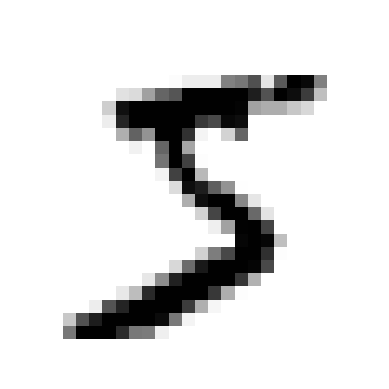

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(shuffle=True, n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9669, 0.91625 and 0.96785

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
recall_score(y_train_5, y_train_pred)

0.8370879772350012


0.6511713705958311

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

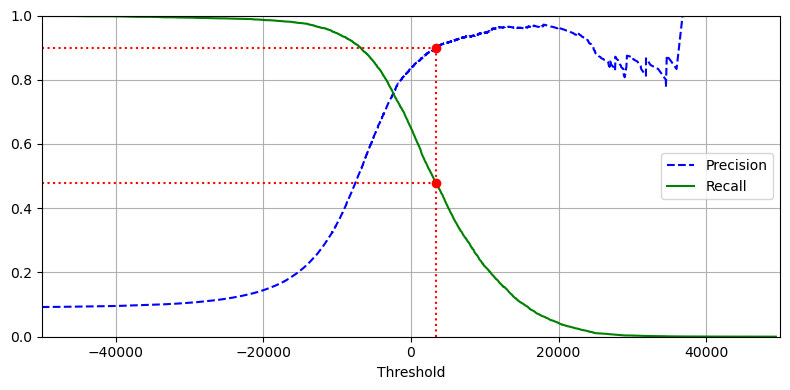

In [23]:
def save_fig(filename, tight_layout = True, fig_extension='png', resolution=200):
    path = 'images/'+f'{filename}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi=resolution)
    return None

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # extra code – this section just beautifies and saves Figure 3–5
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
    idx = (thresholds >= threshold_90_precision).argmax()  # first index ≥ threshold
    plt.plot(thresholds[idx], precisions[idx], "ro")
    plt.plot(thresholds[idx], recalls[idx], "ro")
    plt.vlines(threshold_90_precision, 0, precisions[idx], "r", "dotted")
    plt.hlines(precisions[idx], -50000, threshold_90_precision, 'r', 'dotted')
    plt.hlines(recalls[idx], -50000, threshold_90_precision, 'r', 'dotted')
    plt.axis([-50000, 50000, 0, 1])
    plt.grid()
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    save_fig("precision_recall_vs_threshold_plot")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


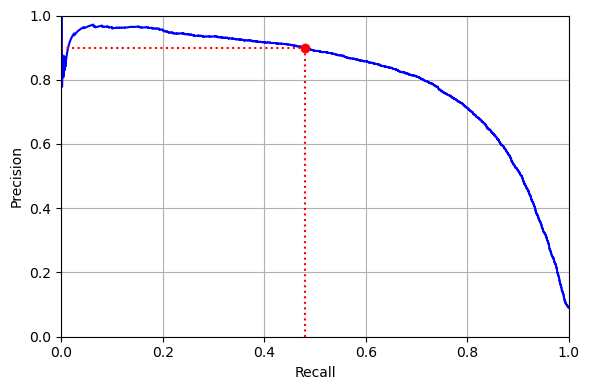

In [24]:
def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.figure(figsize=(6, 4))
    plt.plot(recalls[:-1], precisions[:-1], "b")
    
    # extra code – this section just beautifies and saves Figure 3–5
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
    idx = (thresholds >= threshold_90_precision).argmax()  # first index ≥ threshold
    plt.plot(recalls[idx], precisions[idx], "ro")
    plt.vlines(recalls[idx], 0, precisions[idx], "r", "dotted")
    plt.hlines(precisions[idx], 0, recalls[idx], 'r', 'dotted')
    plt.axis([0, 1, 0, 1])
    plt.grid()
    plt.xlabel("Recall")
    plt.ylabel('Precision')
    save_fig("precision_vs_recall_plot")

plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()


In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~3370
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


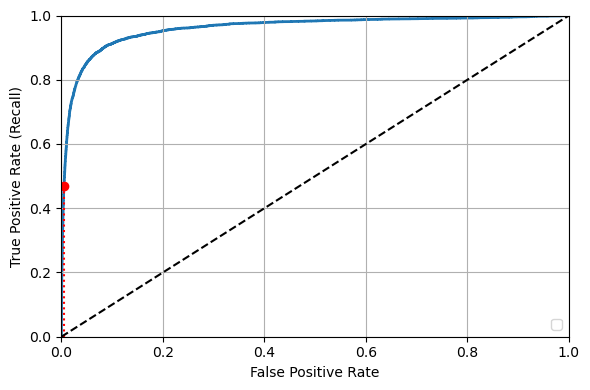

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, zorder=1)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.grid()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc="lower right")
    save_fig('recall_vs_specificity')


plt.figure(figsize=(6, 4))
threshold_45_recall = threshold[np.argmax(fpr >= 0.005)]
idx = (threshold <= threshold_45_recall).argmax()  # first index <= threshold
plt.plot(fpr[idx], tpr[idx], "ro")
plt.vlines(fpr[idx], 0, tpr[idx], "r", "dotted", zorder=2)
plot_roc_curve(fpr, tpr)

plt.show()


In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

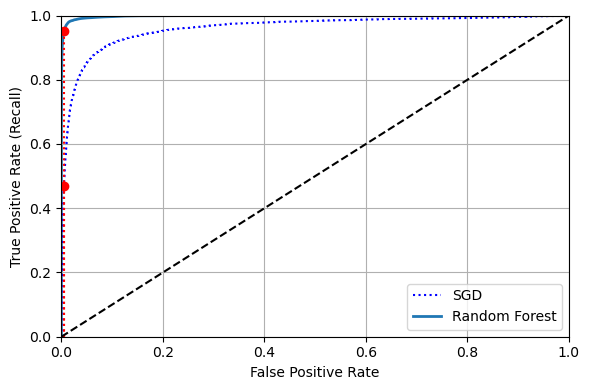

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, "b:", label="SGD")
threshold_45_recall = threshold[np.argmax(fpr >= 0.005)]
idx = (threshold <= threshold_45_recall).argmax()  # first index <= threshold
plt.plot(fpr[idx], tpr[idx], "ro")
plt.vlines(fpr[idx], 0, tpr[idx], "r", "dotted", zorder=2)
threshold_45_recall_forest = thresholds_forest[np.argmax(fpr_forest >= 0.005)]
# first index <= threshold
idx_forest = (thresholds_forest <= threshold_45_recall_forest).argmax()
plt.plot(fpr_forest[idx_forest], tpr_forest[idx_forest], "ro")
plt.vlines(fpr_forest[idx_forest], 0,
           tpr_forest[idx_forest], "r", "dotted", zorder=2)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.show()


In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [32]:
print(precision_score(y_train_5, np.argmax(y_probas_forest, axis=1)))
print(recall_score(y_train_5, np.argmax(y_probas_forest, axis=1)))

0.9905083315756169
0.8662608374838591


In [33]:
np.argmax(y_probas_forest, axis=1)

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [36]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.96445, 0.96255, 0.96645])

In [39]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91545, 0.9131 , 0.92045])

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

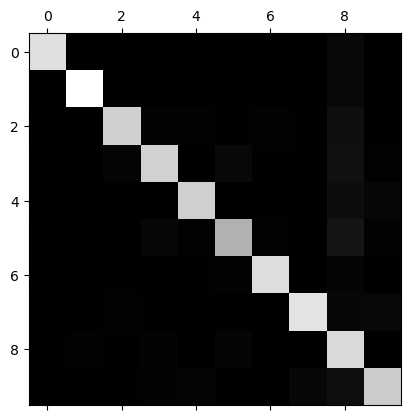

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

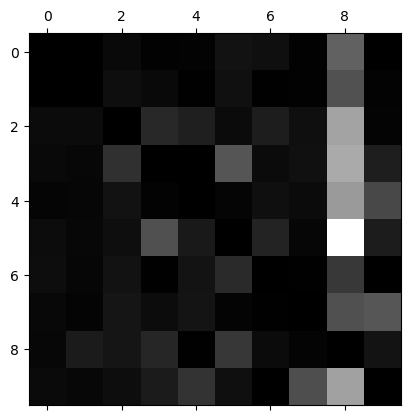

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

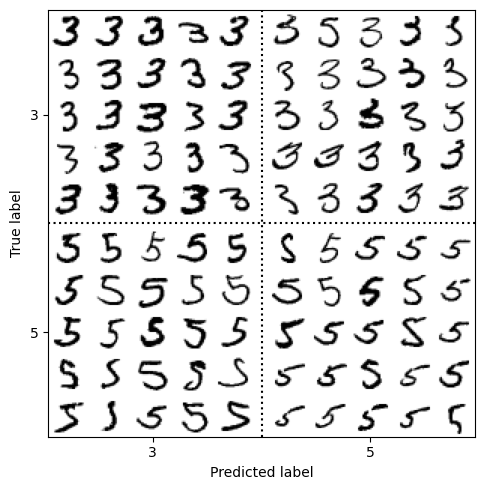

In [42]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

In [45]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [46]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [47]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [49]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

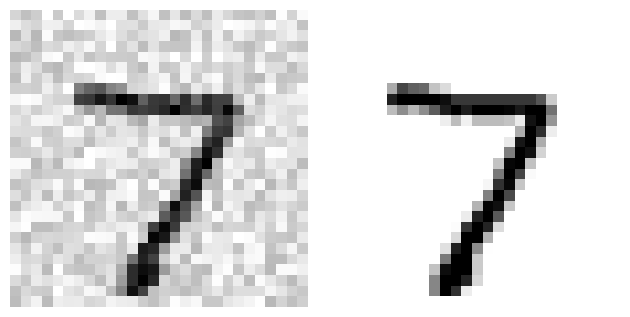

In [54]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

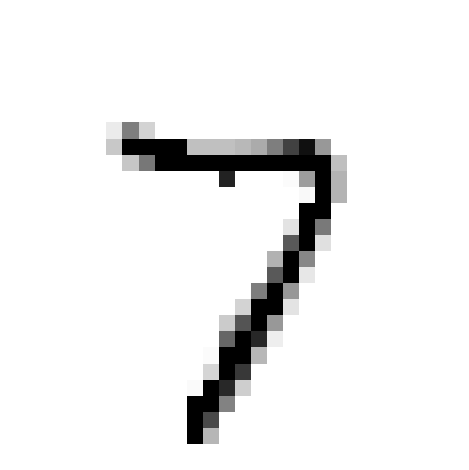

In [55]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()

# Exercise 1
Create a classifier which scores 97% accuracy.

In [57]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)

0.9688

In [59]:
params = {'weights':['distance', 'uniform'],
          'n_neighbors':[1, 3, 5, 10, 20]
          }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=knn_clf, param_grid=params, scoring='accuracy', cv=3)

In [61]:
grid.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10, 20],
                         'weights': ['distance', 'uniform']},
             scoring='accuracy')

In [62]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 3, 'weights': 'distance'}
0.9384995788121104


In [69]:
params = {'weights':['distance'],
          'n_neighbors':[3, 4, 5]
          }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=knn_clf, param_grid=params, scoring='accuracy', cv=5)

In [70]:
grid.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5], 'weights': ['distance']},
             scoring='accuracy')

In [71]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 4, 'weights': 'distance'}
0.9441999999999998


In [73]:
grid.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid.score(X_test, y_test)
tuned_accuracy

0.9714

# Exercise 2 : Data augmentation

In [74]:
from scipy.ndimage import shift

In [77]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

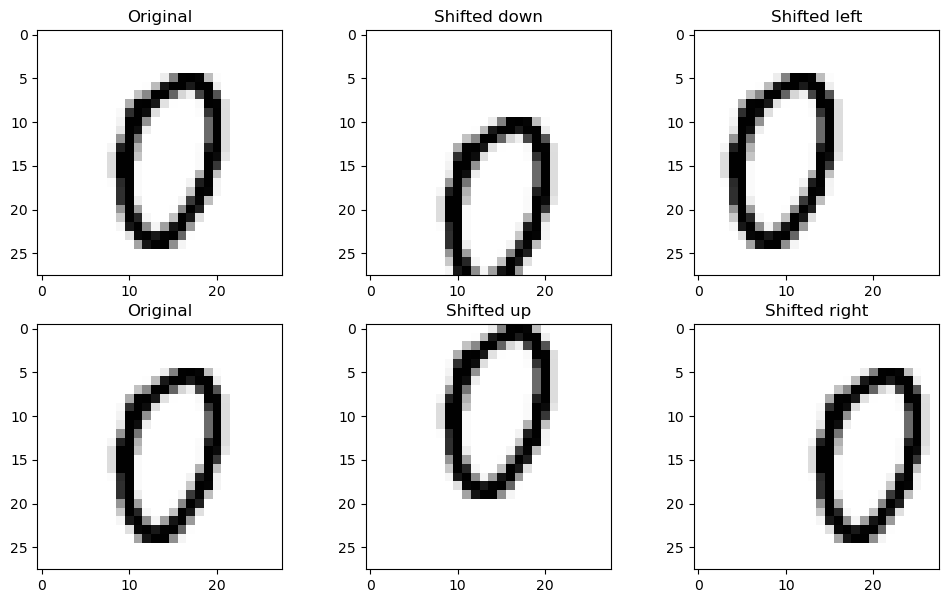

In [83]:
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)
shifted_image_up = shift_image(image, 0, -5)
shifted_image_right = shift_image(image, 5, 0)

plt.figure(figsize=(12, 7))
plt.subplot(231)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(232)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(233)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(234)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(235)
plt.title("Shifted up")
plt.imshow(shifted_image_up.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(236)
plt.title("Shifted right")
plt.imshow(shifted_image_right.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()


In [84]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [85]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [86]:
knn_clf = KNeighborsClassifier(**grid.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [87]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [88]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%
